<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/multiframe_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiframe estimation
#### Qian
#### April 13

If we want to estimate signals of time t (denoted as $\phi_T$), and we have $I_T$ as the **reference** pixel map and $I_{1\sim T-1}$ as **alternatives** pixel maps:

* Demosaicing: alternatives should provide extra sample points where color gets filtered in the reference frame.
* Super-resolution: alternatives should provide extra sample points between pixels of the reference frame.
* Stitching: alternatives should provide extra sample points beyond the reference frame.
---
* Denoising: alternatives should provide extra sample points near the samples of the reference frame.
* All-in-focus: alternatives should provide extra sample points at the region where the reference frame is blurry
* HDR: alternatives should provide extra sample points at the region where the reference frame is saturated or noisy.

Those answers multiframe estimation nature: denser & multiple sampling of the signals gives more accurate estimates. Subpixel-level sampling can be achieved via motions naturally happened in the scene; although we need to find correspondence to align/register samples of a same point or close points.

<img src="https://github.com/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/imgs/align_sample_points.png?raw=1" width="400">

If we visualize the sample points after alignment, typically a large portion of points resides between the original pixel grid of $I_T$. On the contrary to pixel map-based methods that "rounds" each samples to a nearest pixel grid or "distributes" each sample to neighborhod grids, we leave it "as is", because our neural image representation can take arbitrary coordinates and return its radiance. We try to learn a function $\Phi: (x, y) \rightarrow v$ to fit all the aligned points with minimal error.

<img src="https://github.com/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/imgs/neural_representation.png?raw=1" width="300">

## align signal + neural representation pipeline:

Signal alignment is for find pixelwise correspondences. When scenes have a rigid model, or only the camera params changes, we can have those correspondences with calibrated paramemters. In a general scene that we do not have a model of objects and the camera, correspondences has to be estimated. If we use optical flow, this is a process of forward optical flow estimation. 

Practical questions:
* points that share similar destination: estimate occulsion as well.

Neural image representation is implemented by a multi layer perceptron (MLP) $\Phi$, that takes arbitrary point and output color information.

Practical questions:
* In training phase, blurry/saturated/mis-aligned points that needs to be maske-out: use alpha channel to weight final loss when training $\Phi$. (Thoughts from weighted regression)



## Demo:

scene whose model is known (circle with texture rotates some degrees w.r.t. origin)

16 frames in total. 64 x 64 x 3 uint8


In [1]:
# ! unzip -q cbs.zip

In [2]:
def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

Array shape:  (64, 64, 3) dtype: float64
Array stat: max: 0.9882352941176471, min: 0.0, mean: 0.5134293300653595, std: 0.3251563870415135


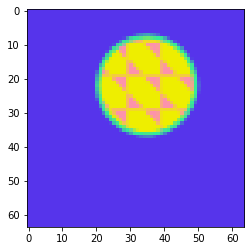

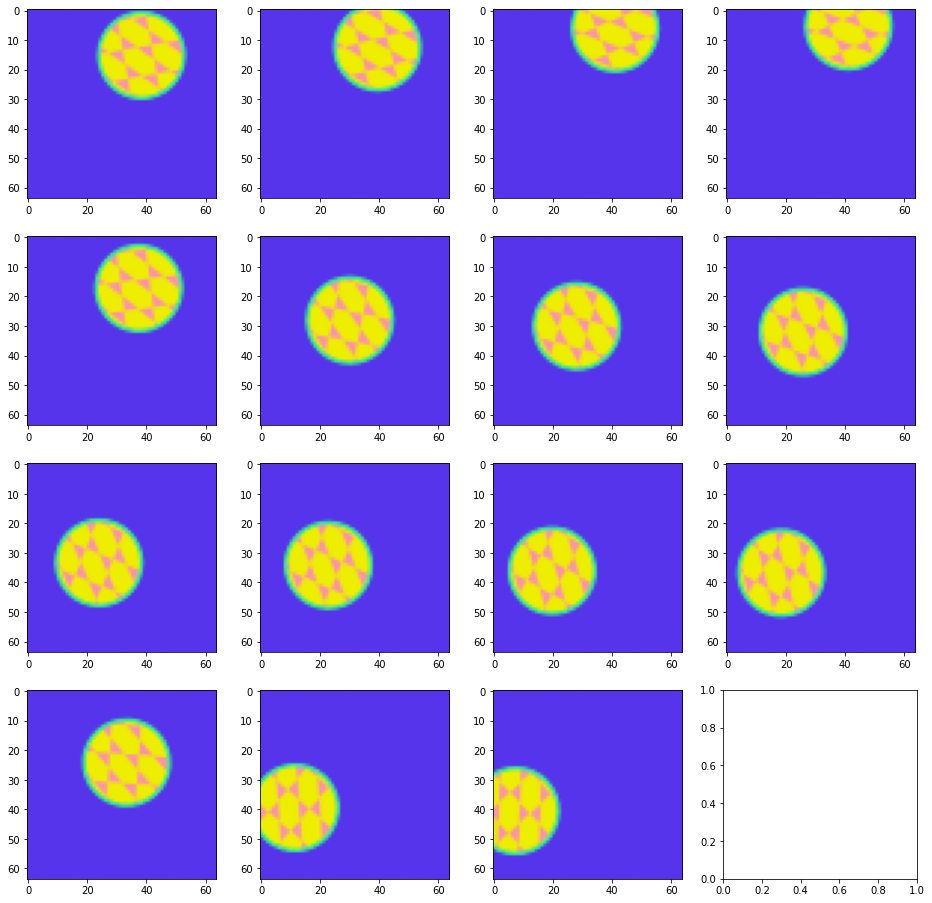

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

degs = ['-10','-14','-23','-24','-7',
        '11', '15', '19', '22', '24', '29','31','4','41','47']
ref = cv2.imread('cb_0.png')[..., ::-1]/255.0
print_stat(ref)
plt.imshow(ref)
plt.show()

fig, ax = plt.subplots(4, 4, figsize = (16, 16))
for i in range(15):
    alt = cv2.imread('cb_{}.png'.format(degs[i]))[..., ::-1]/255.0
    ax[i//4, i % 4].imshow(alt)
plt.show()

align samples regarding the reference frame

In [4]:
coords = np.linspace(0, 1, 64, endpoint=False)
mesh = np.stack(np.meshgrid(coords, coords), -1)

In [5]:
def rot_matrix(deg):
    rad = -deg * np.pi /180.0
    return np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
rot_mat = rot_matrix(-10)
print(rot_mat)

[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]


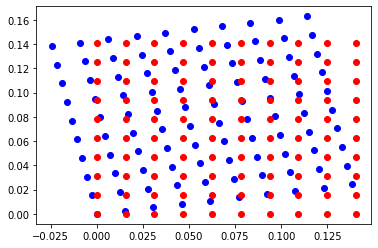

In [6]:
aligned_mesh = rot_mat.dot(mesh.transpose((2, 0, 1)).reshape((2, -1)))
aligned_mesh = aligned_mesh.transpose((1, 0)).reshape(64, 64, 2)
plt.plot(aligned_mesh[:10, :10, 0], aligned_mesh[:10, :10, 1], 'bo',
         mesh[:10, :10, 0], mesh[:10, :10, 1], 'ro')
plt.show()

In [7]:
aligned_meshes = [mesh]
imgs = [ref]
for i in range(15):
    imgs.append(cv2.imread('cb_{}.png'.format(int(degs[i])))[..., ::-1]/255.0)
    rot_mat = rot_matrix(int(degs[i]))
    aligned_mesh = rot_mat.dot(mesh.transpose((2, 0, 1)).reshape((2, -1)))
    aligned_mesh = aligned_mesh.transpose((1, 0)).reshape(64, 64, 2)
    aligned_meshes.append(aligned_mesh)
imgs = np.stack(imgs)
aligned_meshes = np.stack(aligned_meshes)
print(imgs.shape)
print(aligned_meshes.shape)

(16, 64, 64, 3)
(16, 64, 64, 2)


train neural representation with all aligned points

In [8]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

train_data = [aligned_meshes, imgs]

mapping_size = 256
B_gauss = np.random.normal(size=(mapping_size, 2)) * 10.

# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

class pointDataset(torch.utils.data.Dataset):
    def __init__(self, data, B, transform = None):
        self.inputs = data[0]
        self.targets = data[1]
        n, h, w, c = self.inputs.shape
        self.inputs = self.inputs.reshape((n * h * w, -1))
        self.targets = self.targets.reshape((n * h * w, -1))
        self.B = B
        self.transform = transform

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        X = self.inputs[index]
        Y = self.targets[index]
        X = input_mapping(X, self.B)
        if self.transform is not None:
            X = self.transform(X)
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()
        return X, Y

trainset = pointDataset(train_data, B_gauss, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

In [9]:
## build network
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class mlpImage(nn.Module):
    def __init__(self, num_layers, num_channels):
        super(mlpImage, self).__init__()
        layers = OrderedDict(
            [("linear1", nn.Linear(512, num_channels)),
             ("relu1", nn.ReLU(inplace=True)),]
        )
        for i in range(1, num_layers-1):
            layers["linear{}".format(i+1)] = nn.Linear(num_channels, num_channels)
            layers["relu{}".format(i+1)] = nn.ReLU(inplace = True)
        layers["linear{}".format(num_layers)] = nn.Linear(num_channels, 3)
        self.mlp = nn.Sequential(layers)

    def forward(self, x):
        return self.mlp(x)
device = "cuda"
model = mlpImage(4, 256).to(device)
print(model)
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

mlpImage(
  (mlp): Sequential(
    (linear1): Linear(in_features=512, out_features=256, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (relu2): ReLU(inplace=True)
    (linear3): Linear(in_features=256, out_features=256, bias=True)
    (relu3): ReLU(inplace=True)
    (linear4): Linear(in_features=256, out_features=3, bias=True)
  )
)
#total params: 263683 | #trainable params: 263683


In [10]:
## train network
import torch.optim as optim
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

def train(model, optimizer, n_epoch, trainloader, loss_fn):
    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('epoch %d -- loss: %.5f' %
                    (epoch+1, running_loss/(i+1)))
        running_loss = 0.0

    print('Finished Training')

train(model, optimizer, 50, trainloader, loss_fn)

## validate

epoch 1 -- loss: 0.13485
epoch 2 -- loss: 0.05146
epoch 3 -- loss: 0.02674
epoch 4 -- loss: 0.00862
epoch 5 -- loss: 0.00412
epoch 6 -- loss: 0.00289
epoch 7 -- loss: 0.00224
epoch 8 -- loss: 0.00180
epoch 9 -- loss: 0.00148
epoch 10 -- loss: 0.00125
epoch 11 -- loss: 0.00108
epoch 12 -- loss: 0.00095
epoch 13 -- loss: 0.00085
epoch 14 -- loss: 0.00079
epoch 15 -- loss: 0.00073
epoch 16 -- loss: 0.00069
epoch 17 -- loss: 0.00066
epoch 18 -- loss: 0.00062
epoch 19 -- loss: 0.00060
epoch 20 -- loss: 0.00058
epoch 21 -- loss: 0.00056
epoch 22 -- loss: 0.00055
epoch 23 -- loss: 0.00053
epoch 24 -- loss: 0.00052
epoch 25 -- loss: 0.00051
epoch 26 -- loss: 0.00050
epoch 27 -- loss: 0.00049
epoch 28 -- loss: 0.00048
epoch 29 -- loss: 0.00048
epoch 30 -- loss: 0.00047
epoch 31 -- loss: 0.00046
epoch 32 -- loss: 0.00046
epoch 33 -- loss: 0.00045
epoch 34 -- loss: 0.00045
epoch 35 -- loss: 0.00044
epoch 36 -- loss: 0.00044
epoch 37 -- loss: 0.00043
epoch 38 -- loss: 0.00043
epoch 39 -- loss: 0.0

estimate 256x256 frame

In [11]:
model.eval()

coords = np.linspace(0, 1, 256, endpoint=False)
mesh = np.stack(np.meshgrid(coords, coords), -1)[np.newaxis]
test_data = [mesh, mesh]
testset = pointDataset(test_data, B_gauss, transform=None) ## set root to '.' doesnt work
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                          shuffle=False, num_workers=2)

with torch.no_grad():
    img_list = []
    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        outputs = model(inputs).detach()
        img_list.append(outputs)
mlp_img = torch.cat(img_list).cpu().numpy()
mlp_img = mlp_img.reshape((256, 256, 3))

In [12]:
print_stat(mlp_img)

Array shape:  (256, 256, 3) dtype: float32
Array stat: max: 1.0369491577148438, min: -0.08094748854637146, mean: 0.5127468109130859, std: 0.32376402616500854


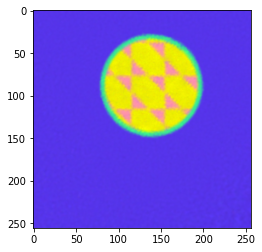

In [13]:
plt.imshow(np.clip(mlp_img, 0, 1))
plt.show()

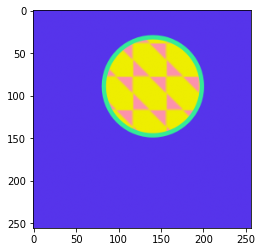

In [14]:
gt = cv2.imread('cb_{}_256.png'.format(0))[..., ::-1]/255.0
plt.imshow(gt)
plt.show()

In [15]:
mse = np.square(mlp_img - gt).mean()
mse

0.002685216943435835

In [16]:
psnr=10*np.log10(1/mse)
psnr

25.710206211260743

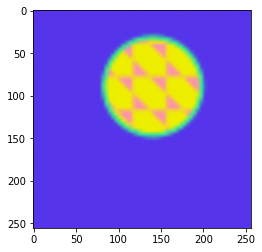

0.0014401061257139072

In [17]:
ref_resize = cv2.resize(ref, (0, 0), fx = 4, fy = 4)
plt.imshow(ref_resize)
plt.show()
mse = np.square(ref_resize - gt).mean()
mse

In [18]:
psnr=10*np.log10(1/mse)
psnr

28.416055022702725